# Demonstrate the "target-decoy" approach, as applied to metagenomic variant calling

In [1]:
%run "Header.ipynb"

In [2]:
import skbio
import pileup
from parse_sco import parse_sco

In [3]:
seq2pos2pileup = pileup.load()

## First: naive variant calling (call a position as "$p$-mutated" if $freq(pos) > p$)

We don't limit to "sufficiently-covered" positions here -- so we consider all regions throughout a genome.

In [4]:
# percentages = [50, 25, 20, 15, 12.5, 10, 7.5, 5, 2, 1, 0.5, 0.25, 0.2, 0.15, 0.1, 0.05]
percentages = [p / 100 for p in range(5, 5001, 5)][::-1]
print(percentages, len(percentages))
p2pct = get_p2pct(percentages)

[50.0, 49.95, 49.9, 49.85, 49.8, 49.75, 49.7, 49.65, 49.6, 49.55, 49.5, 49.45, 49.4, 49.35, 49.3, 49.25, 49.2, 49.15, 49.1, 49.05, 49.0, 48.95, 48.9, 48.85, 48.8, 48.75, 48.7, 48.65, 48.6, 48.55, 48.5, 48.45, 48.4, 48.35, 48.3, 48.25, 48.2, 48.15, 48.1, 48.05, 48.0, 47.95, 47.9, 47.85, 47.8, 47.75, 47.7, 47.65, 47.6, 47.55, 47.5, 47.45, 47.4, 47.35, 47.3, 47.25, 47.2, 47.15, 47.1, 47.05, 47.0, 46.95, 46.9, 46.85, 46.8, 46.75, 46.7, 46.65, 46.6, 46.55, 46.5, 46.45, 46.4, 46.35, 46.3, 46.25, 46.2, 46.15, 46.1, 46.05, 46.0, 45.95, 45.9, 45.85, 45.8, 45.75, 45.7, 45.65, 45.6, 45.55, 45.5, 45.45, 45.4, 45.35, 45.3, 45.25, 45.2, 45.15, 45.1, 45.05, 45.0, 44.95, 44.9, 44.85, 44.8, 44.75, 44.7, 44.65, 44.6, 44.55, 44.5, 44.45, 44.4, 44.35, 44.3, 44.25, 44.2, 44.15, 44.1, 44.05, 44.0, 43.95, 43.9, 43.85, 43.8, 43.75, 43.7, 43.65, 43.6, 43.55, 43.5, 43.45, 43.4, 43.35, 43.3, 43.25, 43.2, 43.15, 43.1, 43.05, 43.0, 42.95, 42.9, 42.85, 42.8, 42.75, 42.7, 42.65, 42.6, 42.55, 42.5, 42.45, 42.4, 42.35

In [5]:
def naive_calling(seq, verbose=True):
    """seqname should be in SEQS.
    
    Returns a tuple with two elements:
    
    1. p2called_mutations: A dict mapping values in "percentages" (defined above) to a list of 1-indexed
       "called" p-mutations in the sequence, using this percentage for p.
       
    2. p2numpermb: A dict with the same keys as p2called_mutations, but the values are the number of called
       p-mutations per megabase (1,000,000 bp = 1 Mbp) in this sequence.   
    """
    p2called_mutations = {p: [] for p in percentages}
    p2numpermb = {}
    seqlen = seq2len[seq]
    for pos in range(1, seqlen + 1):
        if verbose and pos % 100000 == 0:
            print(f"On {seq2name[seq]} position {pos:,} / {seqlen:,} ({100 * (pos / seqlen):.2f}%).")
        pos_pileup = seq2pos2pileup[seq][pos]
        mfa_pct = pileup.get_max_freq_alt_nt_pct(pos_pileup)
        for p in percentages:
            if mfa_pct > p2pct[p]:
                p2called_mutations[p].append(pos)
                
    # We have the equation
    #
    #   # called muts              f
    # ------------------  = ----------------
    #  seq length (bp)        1,000,000 bp
    #
    # We know everything except for f. We can solve for f by multiplying the left side of the
    # equation by 1,000,000 bp. Since the only variable across different thresholds of p is the number
    # of called mutations, we can pre-compute this "constant length factor" (aka 1,000,000 / seq length).
    constant_length_factor = 1000000 / seq2len[seq]
    for p in p2called_mutations:
        num_called_mutations = len(p2called_mutations[p])
        # solve the equation above
        f = num_called_mutations * constant_length_factor
        p2numpermb[p] = f
        if verbose:
            print(f"p = {p}%: {num_called_mutations:,} called p-mutations in {seq2name[seq]}.")
            print(f"\tNumber of called p-mutations per megabase: f = {f:,.2f}.")
        
    return (p2called_mutations, p2numpermb)

### Naively call mutations in CAMP and compute $\mathrm{frac}_{\mathrm{decoy}}$

(We're treating CAMP as a "decoy" genome, where we assume that all called mutations within it will be incorrect.)

In [6]:
camp_naive_p2called_mutations, camp_naive_p2numpermb = naive_calling("edge_6104")

On CAMP position 100,000 / 1,289,244 (7.76%).
On CAMP position 200,000 / 1,289,244 (15.51%).
On CAMP position 300,000 / 1,289,244 (23.27%).
On CAMP position 400,000 / 1,289,244 (31.03%).
On CAMP position 500,000 / 1,289,244 (38.78%).
On CAMP position 600,000 / 1,289,244 (46.54%).
On CAMP position 700,000 / 1,289,244 (54.30%).
On CAMP position 800,000 / 1,289,244 (62.05%).
On CAMP position 900,000 / 1,289,244 (69.81%).
On CAMP position 1,000,000 / 1,289,244 (77.56%).
On CAMP position 1,100,000 / 1,289,244 (85.32%).
On CAMP position 1,200,000 / 1,289,244 (93.08%).
p = 50.0%: 0 called p-mutations in CAMP.
	Number of called p-mutations per megabase: f = 0.00.
p = 49.95%: 0 called p-mutations in CAMP.
	Number of called p-mutations per megabase: f = 0.00.
p = 49.9%: 0 called p-mutations in CAMP.
	Number of called p-mutations per megabase: f = 0.00.
p = 49.85%: 0 called p-mutations in CAMP.
	Number of called p-mutations per megabase: f = 0.00.
p = 49.8%: 0 called p-mutations in CAMP.
	Number 

### For comparison, naively call mutations in BACTERIA and compute $\mathrm{frac}_{\mathrm{BACTERIA}}$

In [7]:
bacteria_naive_p2called_mutations, bacteria_naive_p2numpermb = naive_calling("edge_1671")

On BACTERIA position 100,000 / 2,153,394 (4.64%).
On BACTERIA position 200,000 / 2,153,394 (9.29%).
On BACTERIA position 300,000 / 2,153,394 (13.93%).
On BACTERIA position 400,000 / 2,153,394 (18.58%).
On BACTERIA position 500,000 / 2,153,394 (23.22%).
On BACTERIA position 600,000 / 2,153,394 (27.86%).
On BACTERIA position 700,000 / 2,153,394 (32.51%).
On BACTERIA position 800,000 / 2,153,394 (37.15%).
On BACTERIA position 900,000 / 2,153,394 (41.79%).
On BACTERIA position 1,000,000 / 2,153,394 (46.44%).
On BACTERIA position 1,100,000 / 2,153,394 (51.08%).
On BACTERIA position 1,200,000 / 2,153,394 (55.73%).
On BACTERIA position 1,300,000 / 2,153,394 (60.37%).
On BACTERIA position 1,400,000 / 2,153,394 (65.01%).
On BACTERIA position 1,500,000 / 2,153,394 (69.66%).
On BACTERIA position 1,600,000 / 2,153,394 (74.30%).
On BACTERIA position 1,700,000 / 2,153,394 (78.95%).
On BACTERIA position 1,800,000 / 2,153,394 (83.59%).
On BACTERIA position 1,900,000 / 2,153,394 (88.23%).
On BACTERIA p

### Estimate FDR of BACTERIA mutations, using CAMP as a decoy

In [13]:
p2bacteriafdr = {p: camp_naive_p2numpermb[p] / bacteria_naive_p2numpermb[p] for p in percentages}
for p in percentages:
    print(
        f"Estimated FDR for p = {p}% = "
        f"{camp_naive_p2numpermb[p]:,.2f} / {bacteria_naive_p2numpermb[p]:,.2f} = "
        f"{p2bacteriafdr[p]:}"
    )

Estimated FDR for p = 50.0% = 0.00 / 71.98 = 0.0
Estimated FDR for p = 49.95% = 0.00 / 75.69 = 0.0
Estimated FDR for p = 49.9% = 0.00 / 75.69 = 0.0
Estimated FDR for p = 49.85% = 0.00 / 75.69 = 0.0
Estimated FDR for p = 49.8% = 0.00 / 75.69 = 0.0
Estimated FDR for p = 49.75% = 0.00 / 75.69 = 0.0
Estimated FDR for p = 49.7% = 0.00 / 75.69 = 0.0
Estimated FDR for p = 49.65% = 0.00 / 75.69 = 0.0
Estimated FDR for p = 49.6% = 0.00 / 75.69 = 0.0
Estimated FDR for p = 49.55% = 0.00 / 75.69 = 0.0
Estimated FDR for p = 49.5% = 0.00 / 75.69 = 0.0
Estimated FDR for p = 49.45% = 0.00 / 75.69 = 0.0
Estimated FDR for p = 49.4% = 0.00 / 75.69 = 0.0
Estimated FDR for p = 49.35% = 0.00 / 75.69 = 0.0
Estimated FDR for p = 49.3% = 0.00 / 75.69 = 0.0
Estimated FDR for p = 49.25% = 0.00 / 75.69 = 0.0
Estimated FDR for p = 49.2% = 0.00 / 75.69 = 0.0
Estimated FDR for p = 49.15% = 0.00 / 75.69 = 0.0
Estimated FDR for p = 49.1% = 0.00 / 75.69 = 0.0
Estimated FDR for p = 49.05% = 0.00 / 75.69 = 0.0
Estimated 

### Output info about BACTERIA FDR estimation for $p=0.5\%$ to `misc-text/`

In [9]:
# Total numbers of identified p-mutations
camp1 = len(camp_naive_p2called_mutations[0.5])
bact1 = len(bacteria_naive_p2called_mutations[0.5])
# Scaled numbers of identified p-mutations per megabase (comparable across different-length genomes
# [at least, if you assume that genome length is the only confounding factor here, which it isn't -- we
# should mention this in the paper ofc])
camp2 = camp_naive_p2numpermb[0.5]
bact2 = bacteria_naive_p2numpermb[0.5]
naiveinfo = (
    f"At $p=0.5$\\%, we identified {camp1:,} $p$-mutations in the CAMP genome and {bact1:,} "
    f"$p$-mutations in the BACTERIA genome, corresponding respectively to {camp2:,.2f} and {bact2:,.2f} "
    "$p$-mutations per megabase. If the CAMP genome, which has a relatively low mutation rate, is "
    "selected as a decoy, then we estimate the FDR for the BACTERIA genome as "
    "$\\frac{" + f"{camp2:,.2f}" + "}" + "{" + f"{bact2:,.2f}" + "}" + f" \\approx {p2bacteriafdr[0.5]:.2f}$."
)
with open("misc-text/naive-calling-target-decoy.tex", "w") as of:
    # see https://tex.stackexchange.com/a/18018
    of.write("{}\endinput".format(naiveinfo))

## Plot estimated BACTERIA FDR vs. scaled number of identified mutations

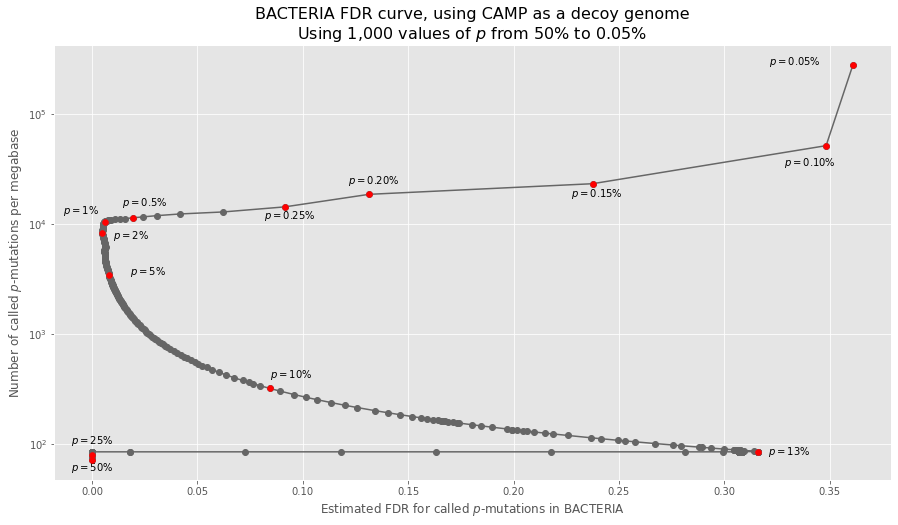

In [37]:
fig, ax = pyplot.subplots(1)

# FDR
x = []
# number of mutations per megabase
y = []
special_xys = []
for p in percentages:
    cx = p2bacteriafdr[p]
    cy = bacteria_naive_p2numpermb[p]
    x.append(cx)
    y.append(cy)
    # add labels (manually positioned). yeah, i know i know
    dy = None
    dx = None
    if p == 50: dy = -15; dx = -0.01
    elif p == 25: dy = 20; dx = -0.01
    elif p == 13: dy = -5; dx = 0.005
    elif p == 10: dy = 80; dx = 0.0
    elif p == 5: dy = 0; dx = 0.01
    elif p == 2: dy = -10**3; dx = 0.005
    elif p == 1: dy = 10**3.3; dx = -0.02
    elif p == 0.5: dy = 10**3.5; dx = -0.005
    elif p == 0.25: dy = -10**3.5; dx = -0.01
    elif p == 0.2: dy = 10**3.65; dx = -0.01
    elif p == 0.15: dy = -10**3.75; dx = -0.01
    elif p == 0.1: dy = -10**4.25; dx = -0.02
    elif p == 0.05: dy = 0; dx = -0.04
    if dy is not None:
        if p >= 1:
            text = f"$p = {p:.0f}\%$"
        elif p >= 0.5:
            text = f"$p = {p:.1f}\%$"
        else:
            text = f"$p = {p:.2f}\%$"
        ax.text(cx + dx, cy + dy, text)
        special_xys.append((cx, cy))
    
ax.plot(x, y, marker="o", color="#666666")
ax.scatter([xy[0] for xy in special_xys], [xy[1] for xy in special_xys], color="#ff0000", zorder=2000)
ax.set_xlabel("Estimated FDR for called $p$-mutations in BACTERIA")
ax.set_ylabel("Number of called $p$-mutations per megabase")
ax.set_title(f"BACTERIA FDR curve, using CAMP as a decoy genome\nUsing 1,000 values of $p$ from {max(percentages):.0f}% to {min(percentages):.2f}%", fontsize=16)
use_thousands_sep(ax.yaxis)
ax.set_yscale("symlog")
fig.set_size_inches(15, 8)
fig.savefig("figs/BACTERIA_FDR_CAMP_decoy.png", bbox_inches="tight")